In [1]:
library(statsecol)
library(jagsUI)
library(MCMCvis)
library(ggplot2)
data("voles")

Warning message:
“package ‘jagsUI’ was built under R version 4.1.1”
Warning message:
“package ‘ggplot2’ was built under R version 4.1.1”


In [ ]:
sink("voles.txt")
cat("
model{
  # Prior specification
  psi1 ~ dunif(0, 1)
  mu ~ dunif(-10, 10)
  sigma ~ dunif(0, 5)
  tau <- sigma^(-2)
  b0 ~ dnorm(0, 0.1)
  b1 ~ dnorm(0, 0.1)
  a0 ~ dnorm(0, 0.1)
  a1 ~ dnorm(0, 0.1)

  for(site in 1:n.sites) {
    for(year in 2:n.years) {
      logit(gamma[site, year - 1]) <- b0 + b1 * connectivity[site]
      logit(epsilon[site, year - 1]) <- a0 + a1 * length[site]
    }
  }
   
  # Likelihood
  for(site in 1:n.sites){
    z[site, 1] ~ dbern(psi1)
    for(year in 2:n.years) {      
      z[site, year] ~ dbern(
        (1 - z[site, year - 1]) * gamma[site, year - 1] + z[site, year - 1] * (1 - epsilon[site, year - 1])
      )
    }
  }

  for(site in 1:n.sites) {
    for(year in 1:n.years) {
      q[site, year] ~ dnorm(mu, tau)
      logit(p[site, year]) <- q[site, year]
      y[site, year] ~ dbinom(p[site, year] * z[site, year], visits[site, year])

      ysim[site, year] ~ dbin(p[site, year] * z[site, year], visits[site, year])
      yexp[site, year] <- p[site, year] * visits[site, year] * z[site, year] + 0.001
      x2.obs[site, year] <- pow((y[site, year] - yexp[site, year]), 2) / (yexp[site, year])    # for observed data
      x2.sim[site, year] <- pow((ysim[site, year] - yexp[site, year]), 2) / (yexp[site, year]) # for 'ideal' data
      ft.obs[site, year] <- pow(sqrt(y[site, year]) - sqrt(yexp[site, year]), 2)               # for observed data
      ft.sim[site, year] <- pow(sqrt(ysim[site, year]) - sqrt(yexp[site, year]), 2)            # for 'ideal' data
    }
  }

  Chi2.obs <- sum(x2.obs[,])
  Chi2.sim <- sum(x2.sim[,])
  Chi2.ratio <- x2.obs/x2.sim
  FT.obs <- sum(ft.obs[,])
  FT.sim <- sum(ft.sim[,])
  FT.ratio <- FT.obs/FT.sim

  for(year in 1:n.years){
    propocc[year] <- sum(z[, year]) / n.sites
  }
}
",fill = TRUE)
sink()

In [2]:
visits = as.matrix(voles[,c("j1", "j2", "j3", "j4")])
obs = as.matrix(voles[, c("y1", "y2", "y3", "y4")])

In [3]:
proj = matrix(rep(NA, 114 * 5), byrow=TRUE, ncol=5)
proj_visits = matrix(sample(c(1,2,3,4), 114 * 5, replace=TRUE), byrow=TRUE, ncol=5)

In [10]:
# Bundle data
volesdata <- list(
    y = obs,
    n.years = 4,
    n.sites = nrow(voles),
    visits = visits,
    connectivity = voles$Connectivity,
    length = voles$Length
)

volesinits <- function() {
  list(psi1 = runif(1, 0, 1),
       mu = runif(1, 0, 1),
       sigma = runif(1, 0, 3),
       b0 = runif(1, 0.4, 0.9),
       b1 = runif(1, 0.4, 0.9),
       a0 = runif(1, 0.1, 0.5),
       a1 = runif(1, 0.7, 0.9),
       z = ifelse(obs>0,1,0)
       )
}

# Parameters monitored
volesparams <- c("gamma", "epsilon", "p", "propocc", 
                 "Chi2.obs", "Chi2.sim", "Chi2.ratio",
                 "FT.obs", "FT.sim", "FT.ratio")

# MCMC settings
ni <- 10000
nt <- 6
nb <- 3000
nc <- 3

volesout <- jags(
    data = volesdata,
    inits = volesinits,
    parameters.to.save = volesparams,
    model.file = "voles.txt",
    n.chains = nc,
    n.iter = ni,
    n.burnin = nb,
    n.thin = nt
)


Processing function input....... 


Warning message in process.input(data, parameters.to.save, inits, n.chains, n.iter, :
“Number of iterations saved after thinning is not an integer; JAGS will round it up.”



Done. 
 
Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 456
   Unobserved stochastic nodes: 1375
   Total graph size: 11995

Initializing model

Adaptive phase..... 
Adaptive phase complete 
 

 Burn-in phase, 3000 iterations x 3 chains 
 

Sampling from joint posterior, 7000 iterations x 3 chains 
 

Calculating statistics....... 

Done. 


In [ ]:
MCMCtrace(volesout,                 #the fitted model
          params = volesparams[1:3],  #core model parameters
          iter = ni,                #plot all iterations
          pdf = FALSE,              #DON'T write to a PDF
          type = "trace",
          ind=TRUE)

Warning message:
“Continuous limits supplied to discrete scale.
Did you mean `limits = factor(...)` or `scale_*_continuous()`?”


Year,Estimate,Lower,Upper
<int>,<dbl>,<dbl>,<dbl>
2009,0.52,0.48,0.57
2010,0.60,0.56,0.66
2011,0.66,0.62,0.70
2012,0.70,0.67,0.75


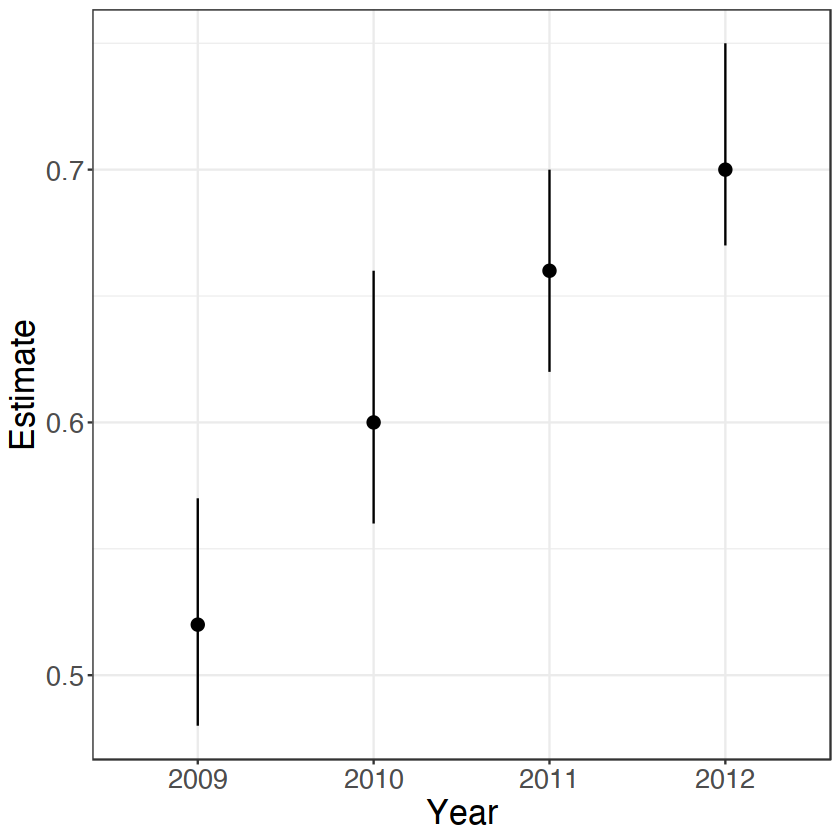

In [20]:
 occupancy <- data.frame(
    Year=c(2009:2012),
    Estimate=round(volesout$mean$propocc,2),
    Lower=round(volesout$q2.5$propocc,2),
    Upper=round(volesout$q97.5$propocc, 2)
)


ggplot(data = occupancy, aes(x=Year,y=Estimate)) + 
  geom_errorbar(aes(ymin=Lower, ymax=Upper), width=0) +
  geom_point(size=3) +
  theme_bw() + theme(
      text = element_text(size=20),
      panel.background = element_blank()
  ) + scale_x_discrete(limits=occupancy$Year)

occupancy

In [14]:
MCMCsummary(
    volesout,
    params =  volesparams[2:3]) #out parameters of interest

,mean,sd,2.5%,50%,97.5%,Rhat,n.eff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"epsilon[1,1]",0.2015889,0.03696334,0.1297164,0.2007770,0.2759345,1.01,214
"epsilon[2,1]",0.1886060,0.03892742,0.1144548,0.1879712,0.2697131,1.01,284
"epsilon[3,1]",0.2068274,0.03688534,0.1341955,0.2062070,0.2819124,1.01,199
"epsilon[4,1]",0.2089419,0.03697534,0.1355733,0.2081584,0.2846314,1.01,194
"epsilon[5,1]",0.2068274,0.03688534,0.1341955,0.2062070,0.2819124,1.01,199
"epsilon[6,1]",0.2033620,0.03688912,0.1308362,0.2028321,0.2772484,1.01,208
"epsilon[7,1]",0.1987665,0.03718102,0.1269600,0.1979979,0.2734553,1.01,225
"epsilon[8,1]",0.2014533,0.03697101,0.1295783,0.2006791,0.2759934,1.01,214
"epsilon[9,1]",0.3815560,0.14103131,0.1211949,0.3773318,0.6628841,1.00,627


In [16]:
length(c(rep("Occupancy",4),
    rep("Colonisation",114),
    rep("Extinction",114)))

[1] 232

In [40]:
mean(obs.chi>sim.chi)
mean(obs.ft>sim.ft)

[1] 0.4755784

[1] 0.4827192

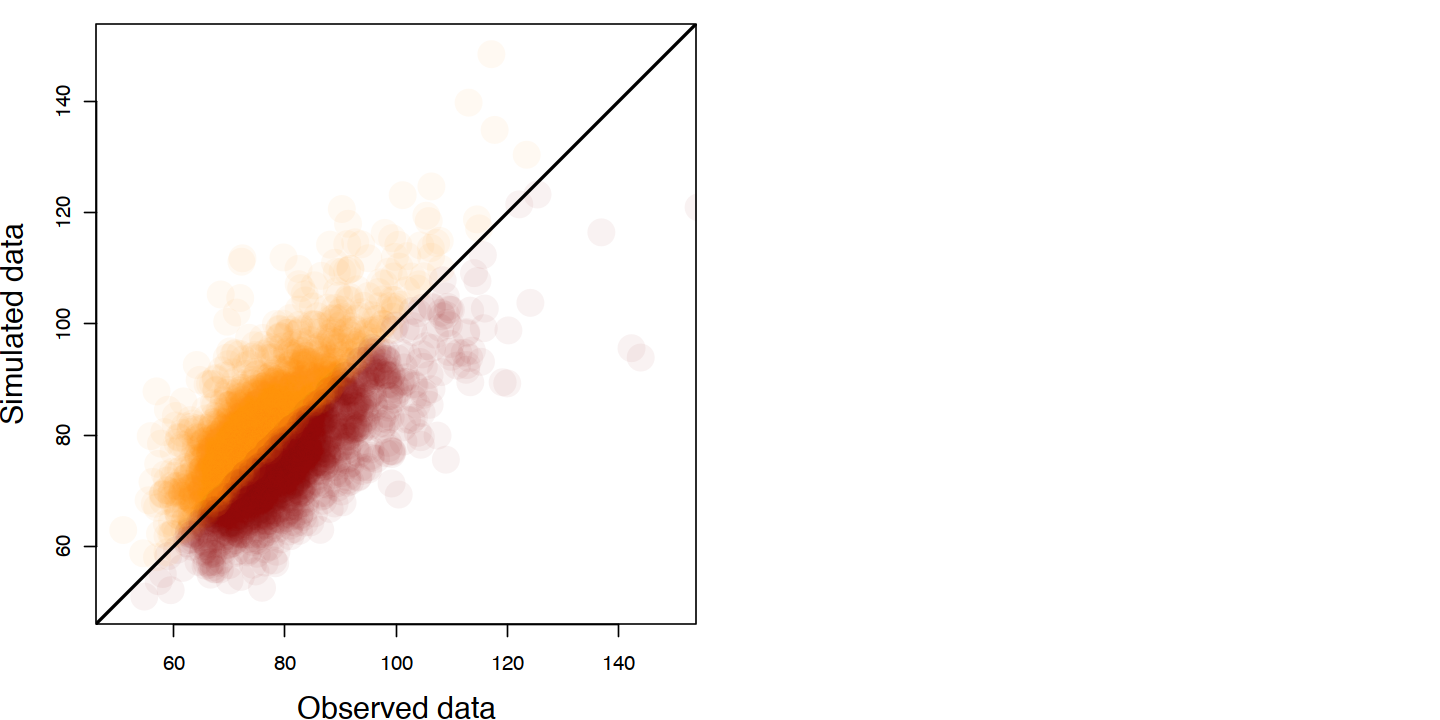

In [39]:
obs.chi <- volesout$sims.list$Chi2.obs
sim.chi <- volesout$sims.list$Chi2.sim
obs.ft <- volesout$sims.list$FT.obs
sim.ft <- volesout$sims.list$FT.sim

options(repr.plot.width=12, repr.plot.height=6)
par(mfrow=c(1,2), oma=c(0,0,0,0), mar=c(4,4,1,1))
plot(sim.chi~obs.chi,col=adjustcolor(ifelse(obs.chi>sim.chi, "darkred","darkorange"),0.05), 
     pch=16, asp=1, xlab="Observed data", ylab="Simulated data",
     xlim=c(50, 150), ylim=c(50, 150), cex=3, cex.lab=1.5, cex.main=1.5)
abline(0,1, lwd=2)
#some_data = data.frame(Obs=obs.chi, Sim=sim.chi)
#ggplot(data=some_data, aes(x=Obs, y=Sim))
#plot(sim.ft~obs.ft,col=adjustcolor(ifelse(obs.ft>sim.ft, "red","gold"),0.05), 
#     pch=16, asp=1, xlab="Observed FT distribution", ylab="Simulated FT distribution", xlim=c(40, 100), ylim=c(40, 100))
#abline(0,1, lwd=2)

In [35]:
cor(voles$Length, volesout$mean$epsilon[,1])

[1] 0.993848

Warning message:
“Ignoring unknown parameters: line_type”


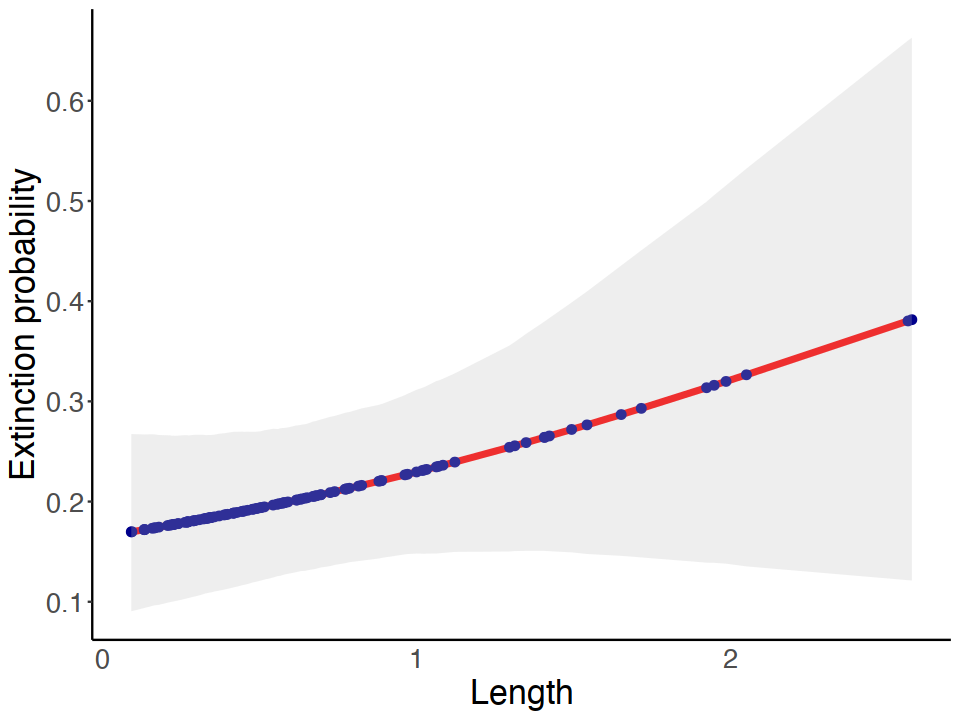

In [53]:
options(repr.plot.width=8, repr.plot.height=6)
lengthepsilon = data.frame(
    Length = voles$Length,
    Epsilon = volesout$mean$epsilon[,1],
    Lower = volesout$q2.5$epsilon[,1],
    Upper = volesout$q97.5$epsilon[,1]
)

ggplot(data = lengthepsilon, 
       aes(x = Length, y = Epsilon)) +
       geom_line(line_type="dotted", color="red", size=1.5) +
       geom_point(color="darkblue", size=2) +
       geom_ribbon(aes(x=Length, y=Epsilon, ymin=Lower, ymax=Upper),
              fill="grey", alpha = 0.25) +
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), 
        axis.line = element_line(colour = "black"),
        text = element_text(size=20),
        axis.ticks.x=element_blank()) + ylab("Extinction probability")



Warning message:
“Ignoring unknown parameters: line_type”


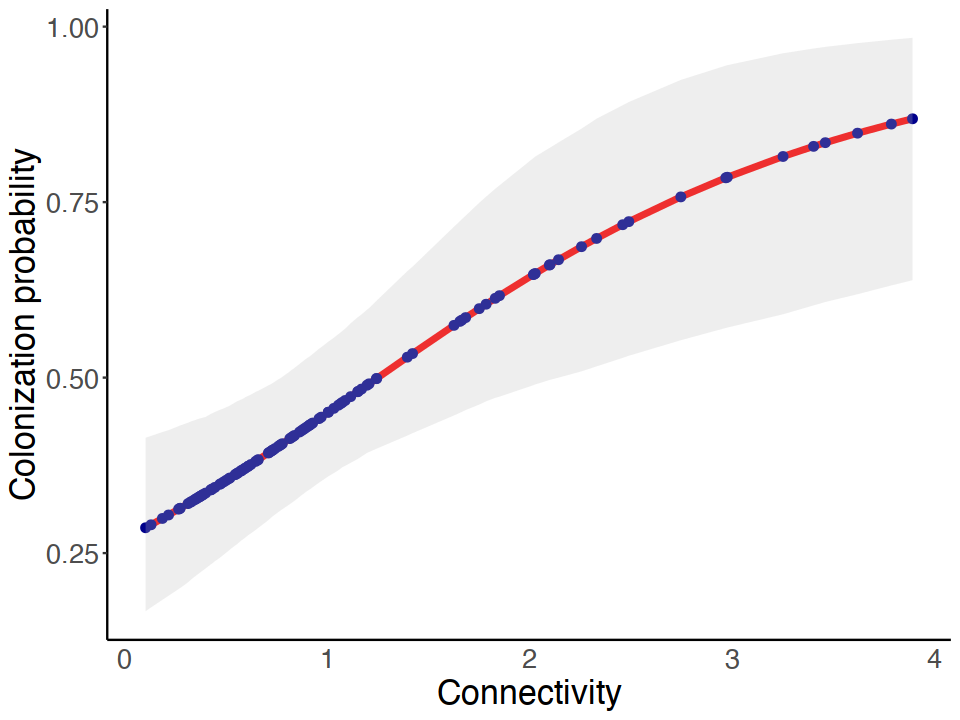

In [60]:
options(repr.plot.width=8, repr.plot.height=6)
#plot(volesout$mean$gamma[,1], voles$Connectivity)
#cor(volesout$mean$gamma[,1], voles$Connectivity)

options(repr.plot.width=8, repr.plot.height=6)
lengthepsilon = data.frame(
    Connectivity = voles$Connectivity,
    Colonization = volesout$mean$gamma[,1],
    Lower = volesout$q2.5$gamma[,1],
    Upper = volesout$q97.5$gamma[,1]
)

ggplot(data = lengthepsilon, 
       aes(x = Connectivity, y = Colonization)) +
       geom_line(line_type="dotted", color="red", size=1.5) +
       geom_point(color="darkblue", size=2) +
       geom_ribbon(aes(x=Connectivity, y=Colonization, ymin=Lower, ymax=Upper),
              fill="grey", alpha = 0.25) + 
       theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        panel.background = element_blank(), 
        axis.line = element_line(colour = "black"),
        text = element_text(size=20),
        axis.ticks.x=element_blank()) + ylab("Colonization probability")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



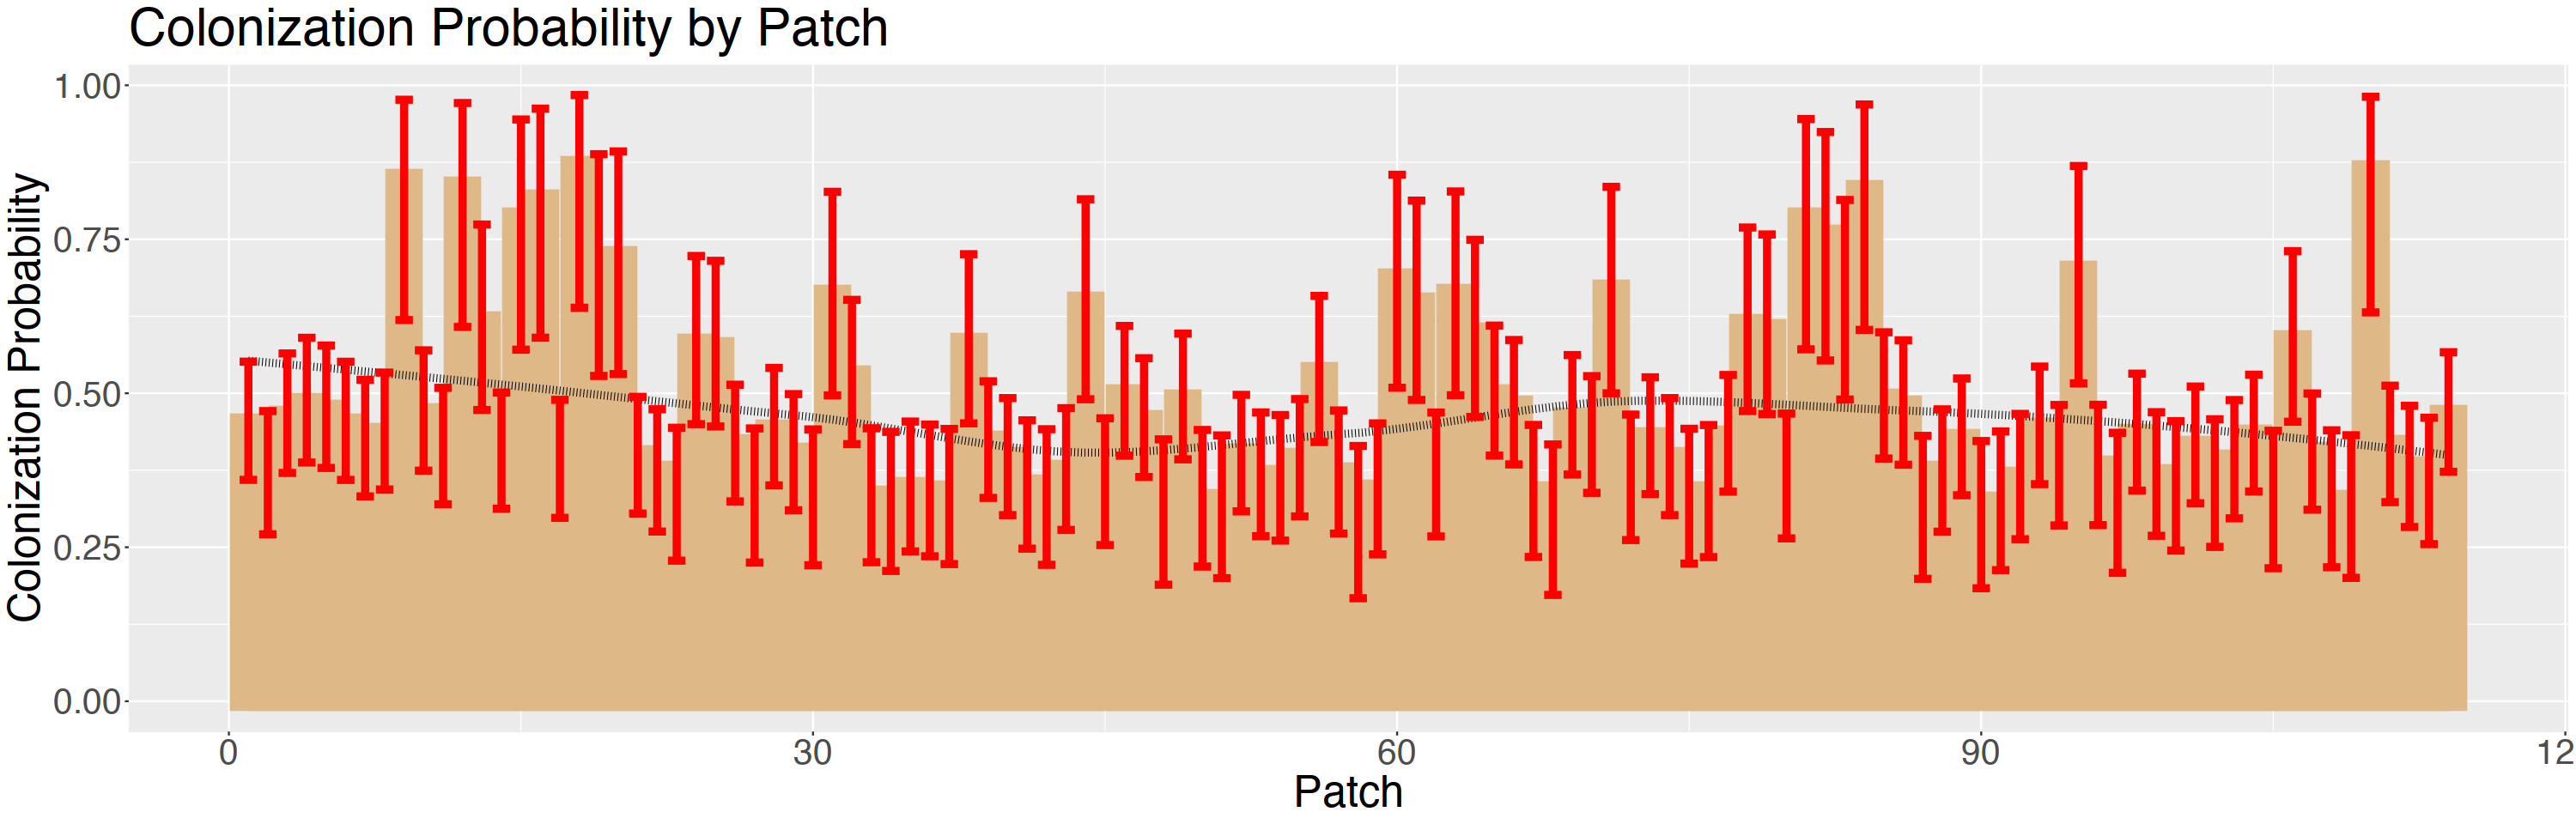

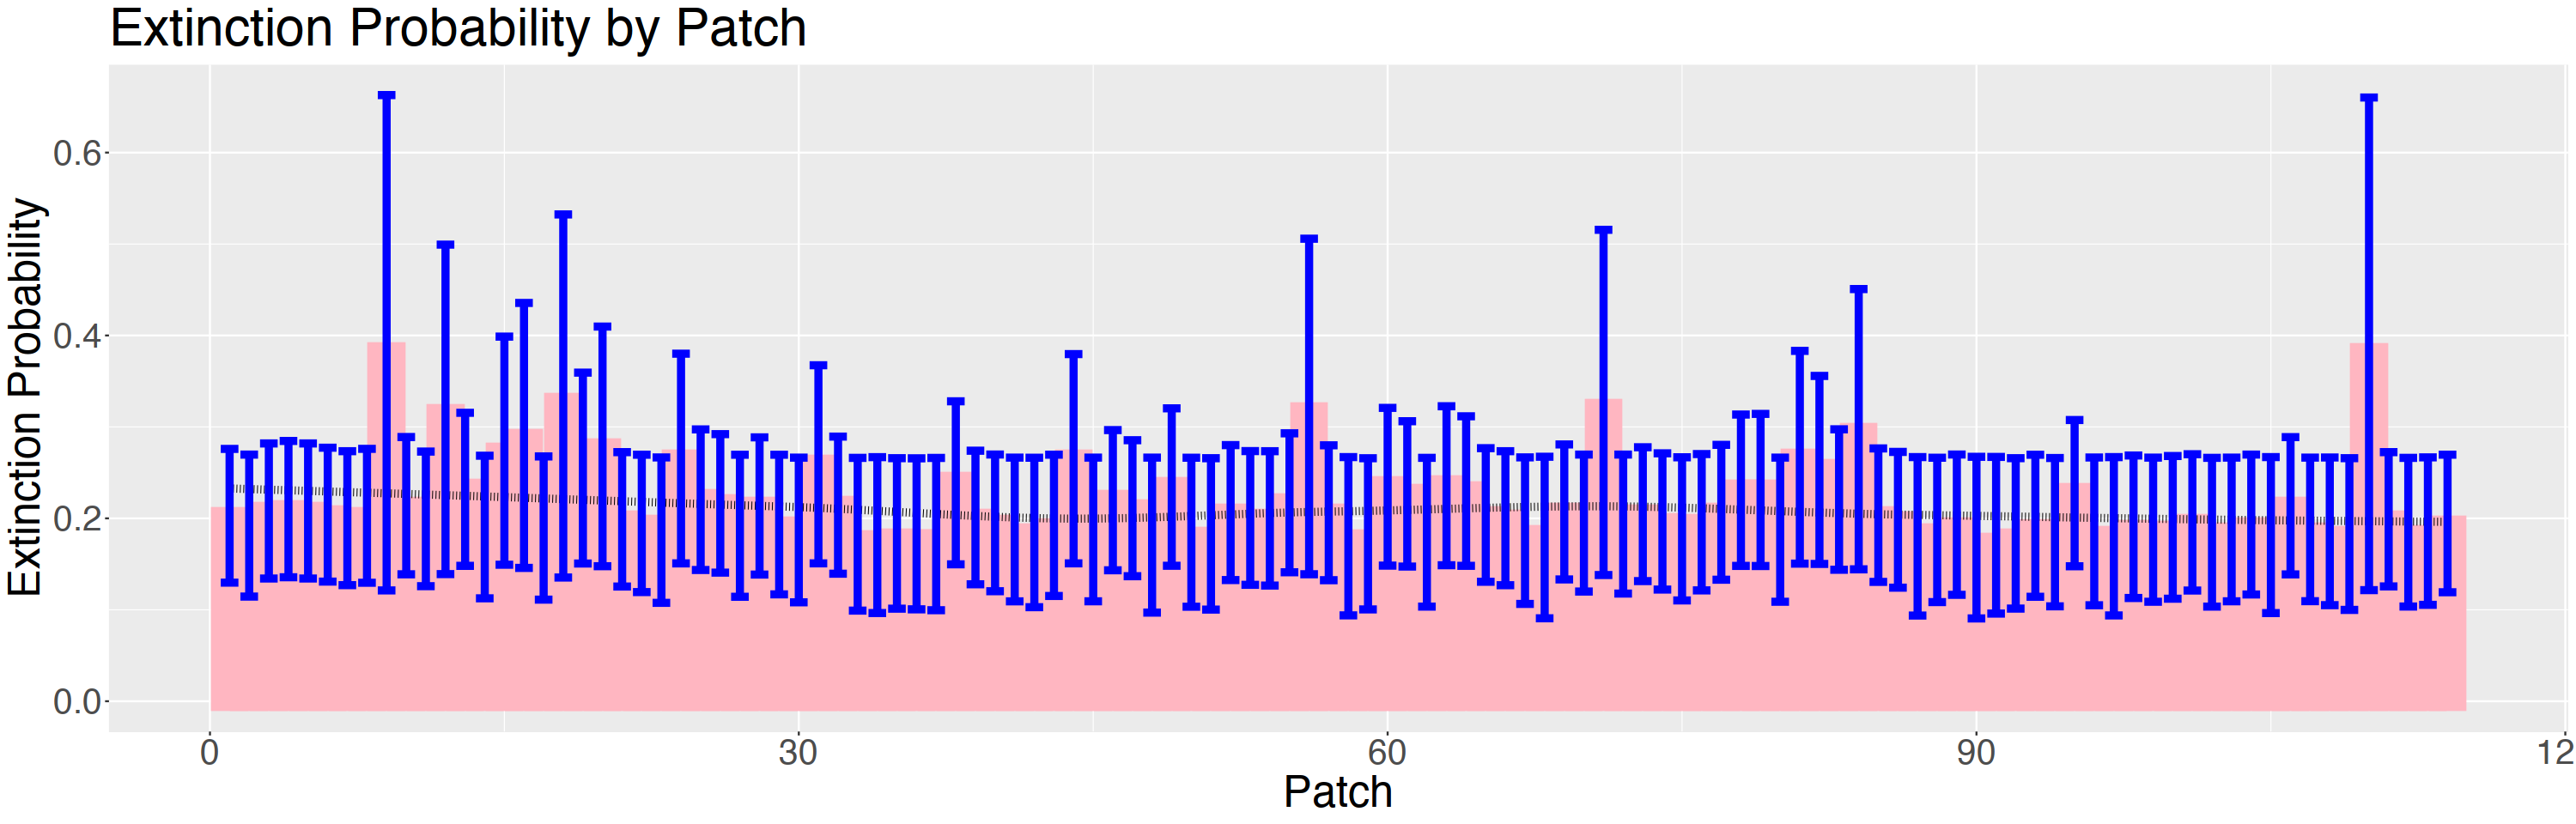

In [24]:
horizontal_dta = data.frame(patch = c(1:114),
                            lower_ep = volesout$q2.5$epsilon[,1],
                            mean_ep = volesout$mean$epsilon[,1],
                            upper_ep =  volesout$q97.5$epsilon[,1],
                            lower_gam = volesout$q2.5$gamma[,1],
                            mean_gam = volesout$mean$gamma[,1],
                            upper_gam = volesout$q97.5$gamma[,1])
options(repr.plot.width=25, repr.plot.height=8)
ggplot(data = horizontal_dta, 
            aes(x = patch, 
            y = mean_gam))+geom_bar(stat = "identity",colour = 'burlywood',size = 5)+geom_smooth(colour = "black", size = 2,linetype = "dotted", se = F)+
geom_errorbar(aes(ymin = lower_gam, ymax = upper_gam), color = "red", size = 2)+ labs(x = "Patch", y = "Colonization Probability", title = "Colonization Probability by Patch")+
    theme(text = element_text(size=30))

ggplot(data = horizontal_dta, 
            aes(x = patch, 
            y = mean_ep))+geom_bar(stat = "identity",colour = 'lightpink',size = 5)+geom_smooth(colour = "black", size = 2,linetype = "dotted", se = F)+
geom_errorbar(aes(ymin = lower_ep, ymax = upper_ep), color = "blue", size = 2)+ labs(x = "Patch", y = "Extinction Probability", title = "Extinction Probability by Patch")+
    theme(text = element_text(size=30))